In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Window(wavelength_array, pixel_size, window_size_multiplier, ngal = 1):
        """Returns windows to run the Model function over to speed up calculation
        Parameters: wavelength_array: Full wavelength array of MMT BinoSpec. This is constant
                    ngal: number of galaxies in a given data file
                    pixel_size: width of pixels in wavelength_array
                    window_size_multiplier: Multiple this with pixel size to get width of window in wavelength_array space
        Returns: nwindow_ndarray: l x m x n ndarray where l = ngal, m = number of windows and 
                                n = pixels per windowsize
        """

        nwindow = (wavelength_array[-1] - wavelength_array[0])//pixel_size #number of windows per galaxy. 
                                                        #It is of this form b/c beyond this window exceeds the wavelength_array
        nwindow_array = []

        #Generate nwindow windows
        for i in range(int(nwindow)):
            tmp = np.arange(wavelength_array[i], wavelength_array[i] + pixel_size*(window_size_multiplier), \
                                         pixel_size)
            if(tmp[-1] > (wavelength_array[-1] + pixel_size)):
                break
            else:
                nwindow_array.append(tmp)

        nwindow_array = np.asarray(nwindow_array)
        
        #Repeat nwindow_arary ngal times 
        #https://stackoverflow.com/questions/32171917/copy-2d-array-into-3rd-dimension-n-times-python
        nwindow_ndarray = np.repeat(nwindow_array[np.newaxis, :, :], ngal, axis=0)

        #return nwindow_ndarray
        return nwindow_array

### Generate wavelength grid with each pixel = 2 Angstrom.

In [6]:
pixel_size = .01
wave_grid = np.arange(4500, 5000, pixel_size);
nwindow = (wave_grid[-1] - wave_grid[0])//pixel_size
print(int(nwindow))
print(len(wave_grid))

49999
50000


### Pass the wavelength grid to the Window function to generate windows to run the model over for
### 1 galaxy, and window width = 5 pixels

In [7]:
tmpwindow = Window(wave_grid, ngal = 1, pixel_size = pixel_size, window_size_multiplier=100)
print(tmpwindow.shape)
tmpwindow

(49902, 100)


array([[4500.        , 4500.01      , 4500.02      , ..., 4500.97      ,
        4500.98      , 4500.99      ],
       [4500.01      , 4500.02      , 4500.03      , ..., 4500.98      ,
        4500.99      , 4501.        ],
       [4500.02      , 4500.03      , 4500.04      , ..., 4500.99      ,
        4501.        , 4501.01      ],
       ...,
       [4998.99000001, 4999.00000001, 4999.01000001, ..., 4999.96000001,
        4999.97000001, 4999.98000001],
       [4999.00000001, 4999.01000001, 4999.02000001, ..., 4999.97000001,
        4999.98000001, 4999.99000001],
       [4999.01000001, 4999.02000001, 4999.03000001, ..., 4999.98000001,
        4999.99000001, 5000.00000001]])

We have generated an m x n ndarray of arrays that consists of m windows and each window contains n pixels

In [10]:
def ModelO2loop(wavelength_array, width, Amp = 1):
        """Returns the [OII] doublet model
        Parameters: wavelength_array: Full wavelength array of MMT BinoSpec. This is constant and must be odd for lambda0 calc.
                    width: width of the Gaussian doublets. This varies.
                    Amp: Amplitude of the Gaussian doublets
        """
        
        Gaussian = lambda x, mean, std: np.exp(-((x[:, np.newaxis] - mean)/std)**2)

        #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
        separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines
        lambda0 = wavelength_array[:,(len(wavelength_array[0])+1)//2] #Take the midpoint of the wavelength_array as the centre
                                                                 #of the Gaussian doublet.wavelength_array must be odd
        
        models = []
        for i,j in enumerate(wavelength_array):
            models.append(Amp*(Gaussian(j, lambda0[i]-separation, width) + \
                               Gaussian(j, lambda0[i]+separation, width)))
            
        models = np.asarray(models)
        
        return models

In [11]:
def Model(wavelength, Amp = 1, std = 0.5): #Default, A = 1, std = 0.75
        """Returns the [OII]
        Parameters: Amp: Amplitude of the Gaussian
                    std: sigma of the Gaussian
                    params: tuple of wavelength range and lambda0 (centre point of the doublet Model)
        """

        lambda0 = wavelength[(len(wavelength[:-1])+1)//2]
        Gaussian = lambda x, mean, std: np.exp(-((x - mean)/std)**2)

        #Values from http://classic.sdss.org/dr6/algorithms/linestable.html
        separation = (3729.875-3727.092)/2 #separation between lambda0 and the emission lines

        return Amp*(Gaussian(wavelength, lambda0-separation, std) + Gaussian(wavelength, lambda0+separation, std))

(4740, 4760)

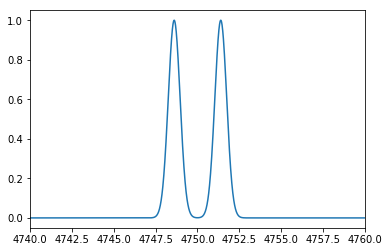

In [12]:
model_reg = Model(wave_grid)
plt.plot(wave_grid, model_reg)
plt.xlim([4740, 4760])